# Importar librerías

- Astropy
- pandas
- numpy


In [1]:
from astropy.io import fits
import numpy as np
import datetime
import pandas as pd
import glob #para linux
from glob import os #para windows
import matplotlib.pyplot as plt
import subprocess
from astropy.visualization import (HistEqStretch, 
                                   simple_norm, 
                                   ImageNormalize, 
                                   imshow_norm, 
                                   MinMaxInterval, 
                                   LogStretch)
from sklearn import preprocessing
import matplotlib.animation as animation
from scipy import ndimage, misc, interpolate
from scipy.optimize import curve_fit
#librerias para iterar colores xd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.cm as mplcm
import matplotlib.colors as colors
#dar formato a las fechas en formato datatime
from matplotlib import dates as mpl_dates
%matplotlib inline

In [2]:
pathToFiles = 'DATA'
orderedList = sorted(glob.glob(os.path.join(pathToFiles, '*.fts')))
contador=0
for filename in orderedList:
    contador+=1
print("\nExisten {} archivos fts".format(contador))


Existen 46 archivos fts


In [3]:
# Obtener lista de datos que son 2048x2048
listaDatos = []
for filename in orderedList:
  hdulist = fits.open(filename)
  data = hdulist[0].data
  hdulist.close
  if data.shape == (2048, 2048):
    listaDatos.append(filename)
print("\nDe los cuales {} son  de tamaño 2048 x 2048".format(len(listaDatos)))



De los cuales 45 son  de tamaño 2048 x 2048


In [4]:
hdulist1 = fits.open(listaDatos[0])
headerList = hdulist1[0].header
hdulist1.close()

maph=pd.DataFrame(columns=headerList)
maph

,SIMPLE,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,DATE-OBS,FILEORIG,SEB_PROG,SYNC,...,FPSDAS3,FPSDAQ1,FPSDAQ2,FPSDAQ3,DATAMDN,HISTORY,HISTORY,HISTORY,HISTORY,HISTORY


In [5]:
cel = []
for i in range(len(listaDatos)):
    hdulist1 = fits.open(listaDatos[i])
    headerList = hdulist1[0].header
    hdulist1.close()
    for headerInplace in headerList:
        cel.append(headerList[headerInplace])
    maph.loc[i]=cel
    cel=[]


In [6]:
expTime=maph.EXPTIME
mExpTime=np.mean(expTime)
mExpTime

6.003693466666666

In [7]:
stdExpTime=np.std(maph.EXPTIME)
stdExpTime

7.744819056681542e-06

In [8]:
#maph = maph[(maph.EXPTIME >= (mExpTime - stdExpTime)) & (maph.EXPTIME <= (mExpTime + stdExpTime))]
maph = maph[(maph.EXPTIME >= (mExpTime - 1.5)) & (maph.EXPTIME <= (mExpTime + 1.5))]
tama = len(maph)
tama

45

In [9]:
listaDatosFiltrados = []
for fit_index in maph.index:
    listaDatosFiltrados.append(listaDatos[fit_index])
len(listaDatosFiltrados)

45

In [10]:
mapa = []
for fit in listaDatosFiltrados:
    hdulist = fits.open(fit)
    datatemp = hdulist[0].data
    hdulist.close()
    
    mapa.append(datatemp)

In [11]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [12]:
map_s = ndimage.uniform_filter(mapa, size=3, mode='reflect')

In [13]:
mitad=1 #esto es para elegir el tamaño de la imagen 2 -> 512# 1 -> 1024
xc=maph.loc[0].CRPIX1/mitad
yc=maph.loc[0].CRPIX2/mitad
print("xc = {}".format(xc))
print("yc = {}".format(yc))

xc = 1027.0
yc = 1028.2


In [14]:
for i in maph:
    if i == 'R_SUN':
        print("R_SUN existe")
    elif i == 'RSUN':
        print("RSUN existe")

RSUN existe


In [15]:
for header in maph:
    if header == 'R_SUN':
        r0=maph.loc[0].R_SUN/(maph.loc[0].CDELT1*mitad)
    elif header == 'RSUN':
        r0=maph.loc[0].RSUN/(maph.loc[0].CDELT1*mitad)

r0_20=20.*r0
r0_19=19.*r0
r0_15=15.*r0
r0_10=10.*r0

In [16]:
print("r0_20 = {}".format(r0_20))
print("r0_19 = {}".format(r0_19))
print("r0_15 = {}".format(r0_15))
print("r0_10 = {}".format(r0_10))

r0_20 = 1364.4457716190345
r0_19 = 1296.2234830380828
r0_15 = 1023.3343287142759
r0_10 = 682.2228858095173


In [17]:
df_tiempo=pd.to_datetime(maph['DATE-OBS'])
df_tiempo.head()

0   2018-11-10 10:24:00.005
1   2018-11-10 10:54:00.005
2   2018-11-10 11:24:00.005
3   2018-11-10 11:54:00.005
4   2018-11-10 12:24:00.005
Name: DATE-OBS, dtype: datetime64[ns]

In [18]:
tiempos = [maph['DATE-OBS']]
header = ["DATE-OBS"]
df_tiempo = pd.concat(tiempos, axis = 1, keys = header)
df_tiempo.head()

,DATE-OBS
0,2018-11-10T10:24:00.005
1,2018-11-10T10:54:00.005
2,2018-11-10T11:24:00.005
3,2018-11-10T11:54:00.005
4,2018-11-10T12:24:00.005


In [19]:
tiempos=pd.to_datetime(df_tiempo['DATE-OBS'])
t0 = tiempos[0] # Esto fallará si se filtro el FITfile con el indice 0
delta = []
for celda in tiempos:
    delta.append((celda - t0).total_seconds())
#delta

In [20]:
df_tiempo['SECONDS'] = delta
df_tiempo.head()

,DATE-OBS,SECONDS
0,2018-11-10T10:24:00.005,0.0
1,2018-11-10T10:54:00.005,1800.0
2,2018-11-10T11:24:00.005,3600.0
3,2018-11-10T11:54:00.005,5400.0
4,2018-11-10T12:24:00.005,7200.0


In [21]:
dx = maph.loc[0]['CDELT1']*1
dx

14.6999998093

In [22]:
#angulo=79.0
n_puntos=100
ang_inc=3.0
#ang_inc=0.5
print('centro = {}, {}'.format(xc,yc))

centro = 1027.0, 1028.2


In [23]:
if maph.loc[0].DETECTOR == 'COR2': #para stereo
    rrin=3
    rrfin=15
else:
    rrin=6
    rrfin=15
rrin

3

In [24]:
def setAngle(angulo, ang_inc, gap):
    gap_angle = np.arange(gap*(-1),gap+1)
    rr=rrt=np.zeros((1+gap*2,2,n_puntos),dtype=int)
    PA_m = angulo + 90
    rsol = r0
    index = np.arange(100)
    rads = np.linspace(rrin,rrfin,100)
    radios = np.zeros(n_puntos)
    for j in gap_angle:
        for i in index:
            rd = rads[i]
            radios[i] = rd
            radio=rsol * rd
            teta = (PA_m + ang_inc * j)*np.pi/180
            x = radio * np.cos(teta) + xc
            y = radio * np.sin(teta) + yc
            if x < 0 or y < 0:
                print(i, x, y)
            rr[j+gap][0][i]=x
            rr[j+gap][1][i]=y
    return rr

In [25]:
#rr = setAngle(79,0.5,5)
rr = setAngle(80,3,5)
print(rr.shape)

(11, 2, 100)


In [26]:
#librerias para iterar colores xd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.cm as mplcm
import matplotlib.colors as colors
#dar formato a las fechas en formato datatime
from matplotlib import dates as mpl_dates

In [27]:
rSolarcsec=32*60
disterr=56./1920./2. ##mitad de la minima escala en Rs para LASCO C3
#if maph[0.DETECTOR eq 'COR2' then disterr= maph(0).CDELT1/rSolarcsec/2. ##mitad de la minima escala en Rs
disterr

0.014583333333333334

In [28]:
if (maph['DETECTOR'][0] == 'COR2'):
    disterr = maph['CDELT1'][0]/rSolarcsec/2
disterr

0.0038281249503385414

In [29]:
radios = np.linspace(rrin,rrfin,100)
#radios

In [30]:
derr = disterr*radios**2
#derr

In [31]:
def fltarr(a,b,c):
    """
    FLTARR(a, b, c)    -> np.zeros((c, b, a))
    """        
    return np.zeros((c,b,a))

In [32]:
#output_idl=fltarr(n_puntos,rr.shape[0],tama) ## con el cambio en la dir radial
output_py=fltarr(n_puntos,rr.shape[0],tama) ## con el cambio en la dir radial

## Codigo en IDL para rellenar output
```idl
for j=0,tama-1 do for k=0,10 do for i=0, n_puntos-1 do $
output(i,k,j) = ( s(rr(i,0,k), rr(i,1,k), j) )
```

## Output python
Esto contiene el valor de brillo de nuestro cono, son:
- Datos sacados de 45 __imagenes__ 
- de las cuales se obtienen 11 __direcciones radiales__ (pueden ser mas o menos de 11)
- dibujados con 100 __puntos__ cada dirección

In [33]:
rr.shape

(11, 2, 100)

 
 ```python
for i in range(tama):
    for j in range(rr.shape[0]):
        for k in range(100):
            #output[i][j][k]    = map_s[    i ][rr[j,1,k]][rr[j,0,k]]
            output_idl[i][j][k] = s_idl[str(i)][rr[j,1,k]][rr[j,0,k]]
```

In [34]:
for i in range(tama):
    for j in range(rr.shape[0]):
        for k in range(100):
            output_py[i][j][k]  = map_s[     i  ][ rr[j,1,k] ][ rr[j,0,k] ]
            #output_idl[i][j][k] = s_idl[ str(i) ][ rr[j,1,k] ][ rr[j,0,k] ]

In [35]:
indtbkg = np.arange(31,44)
indtbkg

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [36]:
def salidaCono():
    global output
    output=fltarr(n_puntos,rr.shape[0],tama)
    for i in range(tama):
        for j in range(rr.shape[0]):
            for k in range(100):
                output[i][j][k]  = map_s[     i  ][ rr[j,1,k] ][ rr[j,0,k] ]

In [37]:
def backgroundError():
    global den_bg_er, den_bgs_er
    den_bg_er  = np.zeros((n_puntos,2))
    den_bgs_er = np.zeros((n_puntos,2))
    for i in range (n_puntos):
        den_bg_er[i][0] = np.mean(output.T[i])
        den_bg_er[i][1] = np.std( output.T[i])
        den_bgs_er[i][0] = np.mean(output[min(indtbkg):max(indtbkg)].T[i])
        den_bgs_er[i][1] = np.std( output[min(indtbkg):max(indtbkg)].T[i])

In [38]:
den_bg_er_py = np.zeros((100,2))

In [39]:
for i in range(n_puntos):
    den_bg_er_py[i][0] = np.mean(output_py.T[i])
    den_bg_er_py[i][1] = np.std(output_py.T[i])

In [40]:
output_py.T.shape

(100, 11, 45)

In [41]:
den_bgs_er=np.zeros((n_puntos,2))  #la den y el sigma de la den del background
for i in range(n_puntos):
    #den_bgs_er[i][0] = np.mean(output_py.T[i][:][min(indtbkg):max(indtbkg)])
    #den_bgs_er[i][1] = np.std( output_py.T[i][:][min(indtbkg):max(indtbkg)])
    den_bgs_er[i][0] = np.mean(output_py[ min(indtbkg):max(indtbkg) ].T[ i ])
    den_bgs_er[i][1] = np.std( output_py[ min(indtbkg):max(indtbkg) ].T[ i ])
#den_bgs_er

In [42]:
den_bgs_er.shape

(100, 2)

# Modo interactivo

In [43]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [44]:
widgets.IntSlider()

IntSlider(value=0)

In [45]:
def direcciones(pa,delta,imagen):
    global rr 
    rr = setAngle(pa,delta,5)
    salidaCono()
    backgroundError()
    radios = np.linspace(3,15,100)
    fig = plt.figure(figsize = (18,6))
    ax = fig.add_subplot(1, 1, 1)
    dic_radios={}
    NUM_COLORS = len(rr)
    cm = plt.get_cmap('seismic')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

    for radio in range(len(rr)):
        valorRadioCentral = np.array([])
        for indice in range(len(listaDatosFiltrados)):
            mapa_temp = map_s[indice]
            valorRadioCentral = np.append(valorRadioCentral,
                                          [mapa_temp[ rr[radio,1,0], rr[radio,0,0] ]] )
        brilloProm = np.mean(valorRadioCentral)
        valorRadioCentral = valorRadioCentral - brilloProm

        dic_radios["radio_No.%s" %radio]=valorRadioCentral
        ax.set_prop_cycle(color=[scalarMap.to_rgba(radio)])
    
        #graficar
        #ax.plot_date(df_tiempo['DATE-OBS'],   
        ax.plot_date(tiempos,   
                     dic_radios["radio_No.%s" %radio], 
                     linestyle='solid',
                     label='Radio %s' %radio)
        #plt.xticks(rotation=45,
        #           ha='right')
        plt.ylim([-80,90])

    #iteración de colores
    ax.grid(color = "#242326")
    ax.legend(ncol=2)
    ax.set_facecolor('#2f2f2f')
    plt.ylabel("Brillo - $\mu_{brillo}$")
    date_format = mpl_dates.DateFormatter('%H:%M \n%d-%b-%Y')
    plt.gca().xaxis.set_major_formatter(date_format)
    
    ax1 = fig.add_subplot(2, 5, 4)
    #datatemp_dif = map_s[30] - map_s[29]
    datatemp_dif = map_s[imagen] - map_s[imagen-1]
    normalized_data = preprocessing.normalize(datatemp_dif, norm="max")
    im,norm = imshow_norm(normalized_data, 
                       ax1, 
                       origin='lower',
                       cmap='gray')

    for j in np.arange(len(rr)):
        ax1.set_prop_cycle(color=[scalarMap.to_rgba(j)])
        ax1.plot(rr[j,0,:],rr[j,1,:], ":")
    #fig.colorbar(im)
    #ax1.get_xaxis().set_visible(False)
    #ax1.get_yaxis().set_visible(False)
    plt.show()

interact(direcciones,
         pa    = widgets.IntSlider(min=0,max=360,step=1, value=80),
         delta = widgets.IntSlider(min=0,max=5,step=1, value=3),
         imagen = widgets.IntSlider(min=2,max=len(map_s)-1,step=1, value=30))
    

interactive(children=(IntSlider(value=80, description='pa', max=360), IntSlider(value=3, description='delta', …

<function __main__.direcciones(pa, delta, imagen)>

## PLOT 1 
bkgnd bright. vs distance.


   ### Código de IDL
```python
for k=0,tama-1 do $
    for j=0,10 do oplot,radios,output(*,j,k),color=15+j*10,linesty=1
```

In [46]:
def brilloBackgroundDistancia(imagen_in, imagen_fin, dir_cono_in, dir_cono_fin):
    NUM_COLORS = 11
    cm = plt.get_cmap('cool')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize = (15,6))
    ax = fig.add_subplot(1, 1, 1)
    for i in np.arange(imagen_in,imagen_fin):
        for j in np.arange(dir_cono_in,dir_cono_fin):
            ax.set_prop_cycle(color=[scalarMap.to_rgba(j)])
            #ax.plot(radios,
            #        output[i,j,:],
            #        #marker='.',
            #        linestyle=':',
            #        markersize=2)
            ax.scatter(radios, output[i,j,:], s=3)
        
    ax.grid(color = "#242326")
    ax.set_facecolor('black')
    plt.ylim([2000,4000])
    plt.xlim([2,16])
    plt.ylabel("Brillo")
    plt.xlabel("Distancia en radios solares")
    plt.show()
    
interact(brilloBackgroundDistancia,
         imagen_in  = widgets.IntSlider(min=0,max=44,step=1, value=0),
         imagen_fin = widgets.IntSlider(min=0,max=44,step=1, value=44),
         dir_cono_in   = widgets.IntSlider(min=0,max=10,step=1, value=0),
         dir_cono_fin  = widgets.IntSlider(min=0,max=10,step=1, value=10))

interactive(children=(IntSlider(value=0, description='imagen_in', max=44), IntSlider(value=44, description='im…

<function __main__.brilloBackgroundDistancia(imagen_in, imagen_fin, dir_cono_in, dir_cono_fin)>

In [47]:
#output = output_py
output.shape

(45, 11, 100)

In [48]:
iti = 0    # imagen al tiempo inicial elegido.
im_ini = 15
try: 
    im_ini
except NameError:
    iti = 0
else:
    iti = im_ini
print('ITI = ', iti)

ITI =  15


In [49]:
limgauss = 16    #vamos a limitar los puntos sobre los que se calc las gauss.s

im_fi = 35
try:
    im_fi 
except NameError:
    limgauss=tama
else:
    limgauss=im_fi 
print('limgauss = ', limgauss)


limgauss =  35


In [50]:
lag=5
try:
    lag_c
except NameError:
    b_corr=0
else:
    b_corr=lag_c

print('b_corr =',  b_corr)

b_corr = 0


## Sacar pa2 y pa2bkg
pa2 = para cada valor de output en i j k (punto, dirección, imagen) se resta el valor mas pequeno de ese punto en esa dirección pero considerando todas la imágenes

pa2bkg = salida del cono menos el promedio de brillo de background para cada punto de los 100 considerando todas las direcciones angulares (`output` - `den_bgs_er`)

In [51]:
pa2=fltarr(n_puntos,11,tama)

In [52]:
pa2bkg=fltarr(n_puntos,11,tama)

In [53]:
for k in range(45):
    for j in range(11):
        for i in range(100):            
            #pa2[k][j][i]   = output[k][j][i] - output[:,j,i].min()
            pa2[k,j,i]     = output[k,j,i]   - output[:,j,i].min()
            #pa2[k][j][i]   = output[k][j][i] - output.T[i][j][:].min()
            pa2bkg[k][j][i]= output[k][j][i] - den_bgs_er[i,0]

In [54]:
den_bgs_er[:,0].min()

2418.25

In [55]:
den_bgs_er[:,0].max()

3412.159090909091

In [56]:
output[:,j,i].min()

2407.0

In [57]:
pa2.shape

(45, 11, 100)

## IDL
```fortran
for i=1,n_puntos-1,5 do oplot,pa2(i,5,*),color=i*15
```

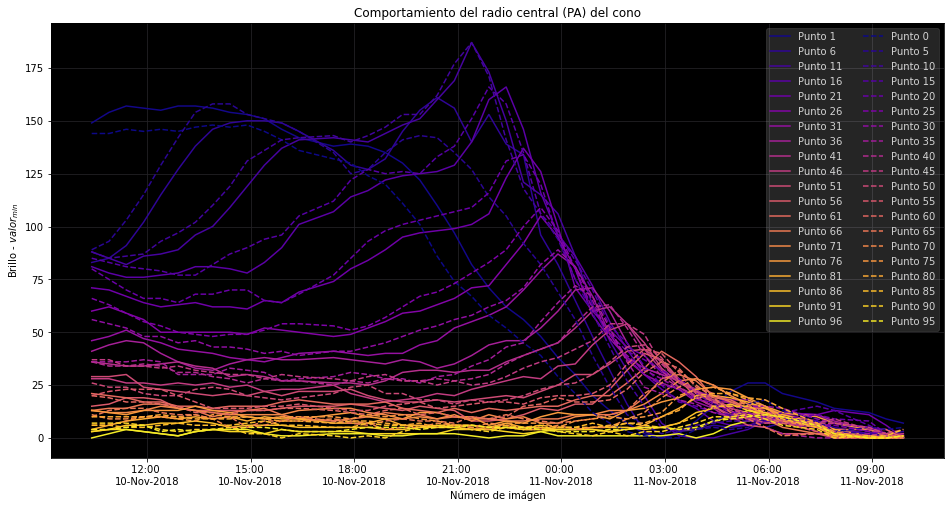

In [58]:
fig = plt.figure(figsize=(16,8))
#cm = plt.get_cmap('nipy_spectral_r')
#cm = plt.get_cmap('gnuplot2_r')
cm = plt.get_cmap('plasma')

N_PUNTOS = 100
cNorm  = colors.Normalize(vmin=0, vmax=N_PUNTOS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax = fig.add_subplot(1,1,1)
for i in np.arange(1,n_puntos, 5):
    ax.set_prop_cycle(color=[scalarMap.to_rgba(i)])
    ax.plot(tiempos,
            pa2.T[i,5,:],
           label='Punto %s' %i, markersize=1)
for j in np.arange(0, n_puntos, 5):
    ax.set_prop_cycle(color=[scalarMap.to_rgba(j)])
    ax.plot(tiempos#np.arange(0,45)
            ,pa2bkg.T[j,5,:]-pa2bkg.T[j,5,:].min(), markersize=3, linestyle='--', label='Punto %s' %j)    
    
date_format = mpl_dates.DateFormatter('%H:%M \n%d-%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
ax.grid(color = "#242326")
ax.legend(ncol=2, framealpha=0.15,labelcolor="#d3d3d3")
ax.set_facecolor('black')
#fig.autofmt_xdate()
plt.ylabel("Brillo - $valor_{min}$")
plt.xlabel('Número de imágen')
plt.title('Comportamiento del radio central (PA) del cono')
plt.show()

In [59]:
pa2.shape

(45, 11, 100)

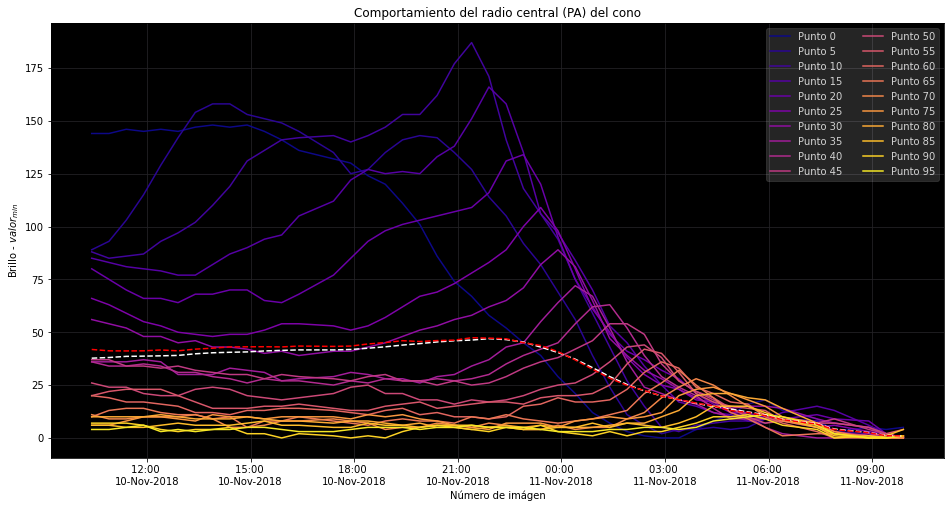

In [60]:
fig = plt.figure(figsize=(16,8))
#cm = plt.get_cmap('nipy_spectral_r')
#cm = plt.get_cmap('gnuplot2_r')
cm = plt.get_cmap('plasma')
N_PUNTOS = 100
cNorm  = colors.Normalize(vmin=0, vmax=N_PUNTOS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
ax = fig.add_subplot(1,1,1)
promedios = np.array([])
for k in range(tama):
    promedios = np.append(promedios,
                          np.mean(pa2[k,5,:]))
promedios2 = np.array([])
for k in range(tama):
    promedios2 = np.append(promedios2,
                          np.mean(pa2[k,5,0:100:5]))
for i in np.arange(0,n_puntos, 5):
    ax.set_prop_cycle(color=[scalarMap.to_rgba(i)])
    ax.plot(tiempos,
            pa2.T[i,5,:],
           label='Punto %s' %i, markersize=1)

plt.plot(tiempos, promedios, 'w', linestyle='--')
plt.plot(tiempos, promedios2, 'r', linestyle='--')
date_format = mpl_dates.DateFormatter('%H:%M \n%d-%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
ax.grid(color = "#242326")
ax.legend(ncol=2, framealpha=0.15,labelcolor="#d3d3d3")
ax.set_facecolor('black')
#fig.autofmt_xdate()
plt.ylabel("Brillo - $valor_{min}$")
plt.xlabel('Número de imágen')
plt.title('Comportamiento del radio central (PA) del cono')
plt.show()

### Para calular los errores:

In [61]:
pa3erm=np.zeros((n_puntos,tama,2))
pa3ero=np.zeros((n_puntos,tama,2))
for i in range(n_puntos):
    for j in range(tama):
        pa3ero[i,j,0] = np.mean(pa2[j,:,i])
        pa3ero[i,j,1] = np.std(pa2[j,:,i])
pa3erm.shape

(100, 45, 2)

In [62]:
pa2.shape

(45, 11, 100)

In [63]:
pa3ero.shape

(100, 45, 2)

In [64]:
pa3ero[0,:,0]

array([74.63636364, 74.27272727, 73.63636364, 73.18181818, 72.27272727,
       70.27272727, 68.36363636, 65.81818182, 64.36363636, 62.72727273,
       60.63636364, 58.36363636, 54.63636364, 51.18181818, 48.63636364,
       47.        , 45.18181818, 42.63636364, 39.54545455, 36.81818182,
       34.09090909, 30.90909091, 28.        , 23.72727273, 19.90909091,
       15.72727273, 12.27272727, 10.        ,  8.36363636,  7.90909091,
        8.27272727,  7.72727273,  7.36363636,  6.        ,  6.18181818,
        7.18181818,  7.45454545,  9.81818182, 10.45454545, 10.81818182,
        9.54545455,  7.81818182,  8.63636364,  8.45454545,  8.72727273])

In [65]:
normg=np.mean(pa3ero[:,:,0])
pa3erm[:,:,0]=pa3ero[:,:,0]/normg
pa3erm[:,:,1]=pa3ero[:,:,1]/normg

In [66]:
pa3er=np.zeros((n_puntos,tama-iti,2))
pa3er[:,:,0]=pa3erm[:,iti:tama,0]
pa3er[:,:,1]=pa3erm[:,iti:tama,1]

In [67]:
pa3er.shape

(100, 30, 2)

In [68]:
tama

45

In [69]:
#delta

In [70]:
tiempo3 = delta[iti:tama]
tama3 = tama - iti
xtemp = tiempo3
xcero = tiempos[0]
xcero

Timestamp('2018-11-10 10:24:00.005000')

In [71]:
len(tiempo3)
len(xtemp)

30

Text(0.5, 0, "Segundos a partir de '2018-11-10 10:24:00.005000'")

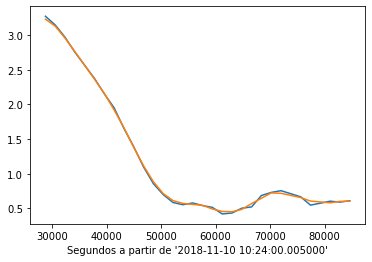

In [72]:
plt.plot(xtemp,pa3er[0,:,0])
plt.plot(xtemp,ndimage.uniform_filter(pa3er[0,:,0], size=3, mode='nearest'))
plt.xlabel("Segundos a partir de '2018-11-10 10:24:00.005000'")

In [73]:
try: 
    lag
except NameError:
    corrim = 0
else:
    corrim = lag
print('lag = ', lag)

lag =  5


In [74]:
try: 
    numter
except NameError:
    ntms = 5
else:
    ntms = numter
print('numero de terminos en el ajuste de curvas = ', ntms)

numero de terminos en el ajuste de curvas =  5


In [75]:
ctelimg=5

In [76]:
tamano=tama3
l_gauss=limgauss
er_arr=pa3er
x_tmp=xtemp
x_0=xcero
n_radios=n_puntos

if (corrim == 0):
    print('Corrimiento = 0')
    bnd=1
    if l_gauss >= tamano:
        l_gauss=tamano -1
    else:
        l_gauss=l_gauss-1
else:
    bnd=0
    print('Corrimiento = 1')
    if (l_gauss > tamano-ctelimg-1):
        l_gauss=tamano-ctelimg 
    else: 
        l_gauss=l_gauss-1

Corrimiento = 1


In [77]:
l_gauss

25

In [78]:
pasal=np.zeros((l_gauss*2,n_radios))
g_ctes=np.zeros((n_radios,9))  #estamos aumentando el termino de 1er

In [79]:
pasal.shape

(50, 100)

In [80]:
g_ctes.shape

(100, 9)

In [81]:
ytemp=np.zeros((l_gauss+1))  #los tiempos que vamos a usar
sigtemp=np.zeros((l_gauss+1))
tsal=np.zeros((l_gauss*2,n_radios))
tctes=np.zeros((n_radios,4)) #el arreglo de las constantes LOS TRES METODOS
tsig=np.zeros((n_radios,5))  #el arreglo de los errores respectivos y chi2
#cplot=fix(findgen(20)/(20./n_radios)) # para checar si ploteamos o no??
cplot=np.arange(0,100,5) # para checar si ploteamos o no??

In [82]:
for j in range(0,10):
    print(j)

0
1
2
3
4
5
6
7
8
9


In [83]:
bnd

0

In [84]:
x_tmp[0:(l_gauss+1)+0]

[28800.0,
 30600.0,
 32400.005,
 34200.001,
 36000.0,
 37800.0,
 39600.0,
 41400.0,
 43200.004,
 45000.003,
 46800.001,
 48600.002,
 50400.0,
 52200.0,
 54000.0,
 55800.001,
 57599.999,
 59400.0,
 61200.0,
 63000.001,
 64800.001,
 66600.001,
 68400.005,
 70200.004,
 72000.001,
 75600.0]

In [85]:
cte1=0
er_arr[0,cte1:l_gauss+1+cte1,0]

array([3.27573171, 3.14901094, 2.97160188, 2.75617658, 2.56609544,
       2.37601429, 2.15425296, 1.95149974, 1.65370595, 1.38759235,
       1.09613459, 0.85536515, 0.69696419, 0.58291551, 0.55123532,
       0.57657947, 0.53856324, 0.51321909, 0.41817852, 0.43085059,
       0.50054701, 0.51955513, 0.68429212, 0.72864438, 0.75398854,
       0.665284  ])

# Interpolar un arreglo
```python
interpfunc = interpolate.interp1d(b,a, kind='linear')
x=interpfuc(c)
```

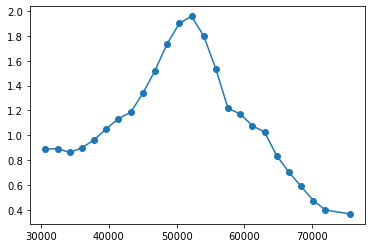

In [86]:
from math import floor as floor
j=35
mfct=(tamano-l_gauss)/n_radios
cte1=floor(j*mfct)
xt=x_tmp[cte1:l_gauss+cte1]
ytemp   =er_arr[j, cte1:l_gauss+cte1, 0]
sigtemp =er_arr[j, cte1:l_gauss+cte1, 1]
#INTERPOLATION
x_sal=(np.arange(l_gauss*2)+1)*(max(xt)-min(xt))/(l_gauss*2)+min(xt)
interpolFunction = interpolate.interp1d(xt, ytemp, kind='quadratic')#, bounds_error=False, fill_value='extrapolate')
inter=interpolFunction(x_sal)

siginterFunction = interpolate.interp1d(xt, sigtemp, kind='quadratic')#, bounds_error=False, fill_value='extrapolate')
siginter = siginterFunction(x_sal)

plt.plot(xt, ytemp, marker='o')
#plt.plot(xt, sigtemp, marker='.')
#plt.plot(x_sal, inter, marker='.')
plt.show()

In [87]:
np.arange(40,45)

array([40, 41, 42, 43, 44])

In [88]:
c = np.polyfit(x_sal, inter, deg=2)
c

array([-2.40542146e-09,  2.43099059e-04, -4.62917660e+00])

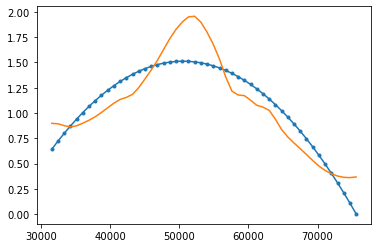

In [89]:
a0 = c[0]
a1 = c[1]
a2 = c[2]
yf = np.array([])
for x in x_sal:
    yf = np.append(yf, a0*x**2 + a1*x + a2)
plt.plot(x_sal, yf, marker=".")
#plt.plot(x_sal, a0*x_sal**2 + a1*x_sal + a2, "y:")
plt.plot(x_sal, inter)
plt.show()

In [90]:
x = x_sal
yd = inter - yf
imax = np.where(yd == yd.max())
for i in imax:
    imax = int(i)
ymax = yd[imax]
xmax = x_sal[imax]
imin = np.where(yd == yd.min())
for i in imin:
    imin = int(i)
ymin = yd[imin]
xmin = x_sal[imin]
print(ymax)
print(imax)
print(xmax)
print(ymin)
#if abs(ymax) gt abs(ymin) then i0=imax else i0=imin ;emiss or absorp?
if abs(ymax) > abs(ymin):
    i0 = imax
else:
     i0 = imin   
n = len(inter)
#i0 = i0 > 1 < (n-2)  #;never take edges
dy = yd[i0]			#;diff between extreme and mean
Delta = dy/np.exp(1.)		#;1/e value

print(dy)
print(Delta)

0.45163011140175957
23
52200.0
-0.198770087375004
0.45163011140175957
0.16614543299867557


In [91]:
print(i0)
print(n)

23
50


In [92]:
print(yd[i0])
print(x[i0])
print(i)

0.45163011140175957
52200.0
[13]


In [93]:
i=0
while (i0 + i + 1 < n) and (i0 - i > 0) and (abs(yd[i0+i]) > abs(Delta)) and (abs(yd[i0-i]) > abs(Delta)):
    print(i)
    i += 1
print(i)


0
1
2
3
4


In [94]:
def emissAbsorb():
    i=0
    while (i0 + i + 1 < n) and (i0 - i > 0) and (abs(yd[i0+i]) > abs(Delta)) and (abs(yd[i0-i]) > abs(Delta)):
        i += 1
    return i
emissAbsorb()

4

In [95]:
a = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
a

[0.45163011140175957, 52200.0, 3600.0]

In [96]:
c

array([-2.40542146e-09,  2.43099059e-04, -4.62917660e+00])

In [97]:
nt = 5
if nt > 3: a = np.append(a, c[2])
if nt > 4: a = np.append(a, c[1])
if nt > 5: a = np.append(a, c[0])
a

array([ 4.51630111e-01,  5.22000000e+04,  3.60000000e+03, -4.62917660e+00,
        2.43099059e-04])

In [98]:
def gauss_funct(x,a0,a1,a2,a3,a4):
    if (a2 != 0):
        z = (x-a1)/a2
        ez = np.exp(-z**2/2)
    else:
        z = 100
        ez = 0.0
    f = a0*ez + a3 + a4*x
    return f


In [99]:
def gauss_funct3(x,a0,a1,a2):
    if (a2 != 0):
        z = (x-a1)/a2
        ez = np.exp(-z**2/2)
    else:
        z = 100
        ez = 0.0
    f = a0*ez
    return f
    
def gauss_funct4(x,a0,a1,a2,a3):
    if (a2 != 0):
        z = (x-a1)/a2
        ez = np.exp(-z**2/2)
    else:
        z = 100
        ez = 0.0
    f = a0*ez + a3
    return f
    
def gauss_funct5(x,a0,a1,a2,a3,a4):
    if (a2 != 0):
        z = (x-a1)/a2
        ez = np.exp(-z**2/2)
    else:
        z = 100
        ez = 0.0
    f = a0*ez + a3 + a4*x
    return f

def gauss_funct6(x,a0,a1,a2,a3,a4,a5):
    if (a2 != 0):
        z = (x-a1)/a2
        ez = np.exp(-z**2/2)
    else:
        z = 100
        ez = 0.0
    f = a0*ez + a3 + a4*x + a5*x**2
    return f


In [100]:
nt = 5 ##############################################################################
if nt == 3:
    i = emissAbsorb()
    a = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
    gauss_funct = gauss_funct3
    
elif nt == 4:
    i = emissAbsorb()
    a = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
    a = np.append(a, c[2])
    gauss_funct = gauss_funct4
                  
elif nt == 5:
    i = emissAbsorb()
    a = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
    a = np.append(a, c[2])
    a = np.append(a, c[1])
    gauss_funct = gauss_funct5
    
elif nt == 6:
    i = emissAbsorb()
    a = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
    a = np.append(a, c[2])
    a = np.append(a, c[1])
    a = np.append(a, c[0])
    gauss_funct = gauss_funct6
    

In [101]:
#popt, pcov = curve_fit(gauss_funct, x_sal, inter, p0=a, sigma=siginter, absolute_sigma=True)
popt, pcov = curve_fit(gauss_funct, 
                       x_sal, 
                       inter, 
                       p0=a)
for i in popt:
    print(i)

1.1624865044756618
52112.35144379822
6843.554254211128
1.2207943160871102
-1.0796375069863927e-05


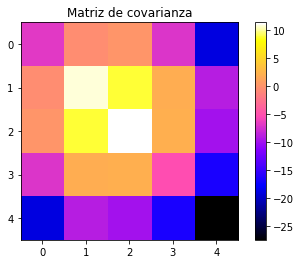

In [102]:
cm = plt.get_cmap('gnuplot2')
plt.imshow(np.log(abs(pcov)), cmap=cm)
plt.colorbar()
plt.title("Matriz de covarianza")
plt.show()

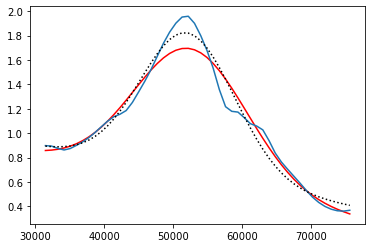

In [103]:
popt2, pcov2 = curve_fit(gauss_funct, 
                         x_sal, 
                         inter, 
                         p0=a, 
                         sigma=siginter, 
                         absolute_sigma=True)
yhat = gauss_funct(x_sal, *popt)
yhatSigmas = gauss_funct(x_sal, *popt2)
#plt.plot(x_sal, yhatSigmas, "#05ff03")  
plt.plot(x_sal, yhatSigmas, "r-")  
plt.plot(x_sal, inter)
plt.plot(x_sal, yhat, "k:")
plt.show()

In [104]:
a

array([ 4.51630111e-01,  5.22000000e+04,  3.60000000e+03, -4.62917660e+00,
        2.43099059e-04])

In [105]:
yhat = gauss_funct(x_sal, *popt)

In [106]:
sum(inter)

54.261645526861294

In [107]:
sum(yhat)

54.26164552960036

In [108]:
sum(yhatSigmas)

53.70147307798658

In [109]:
yhatSigmas = yhatSigmas/sum(yhatSigmas)*sum(inter)
sum(yhatSigmas)

54.26164552686128

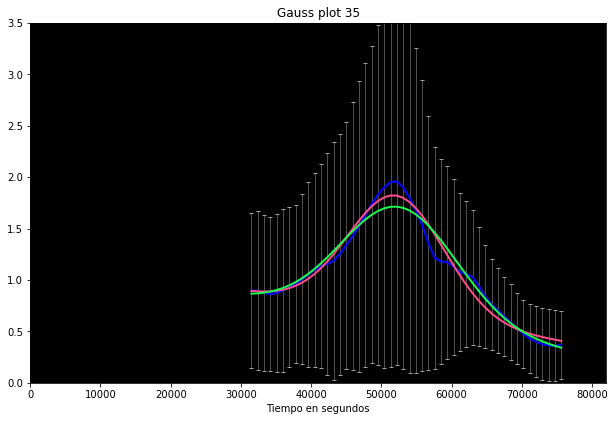

In [110]:
fig = plt.figure(figsize=(8,5), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
#ax.errorbar(xt, ytemp, sigtemp, ecolor="#a1a1a1", barsabove=True, elinewidth = 0.5,  capsize=2)
ax.errorbar(x_sal, inter, siginter, ecolor="#a1a1a1", barsabove=True, elinewidth = 0.5,  capsize=2)
ax.plot(x_sal, inter, 'b', x_sal, yhat, '#fd4c8a', linewidth=2)
ax.plot(x_sal, yhatSigmas, "#1bfa50", linewidth=2, label="No Sigmas")
#ax.plot(x_sal, yf, "r:")
ax.set_facecolor('black')
plt.title("Gauss plot {}".format(j))
plt.xlabel("Tiempo en segundos")
plt.xlim((0,82000))
plt.ylim((0,3.5))
plt.show()

In [111]:
len(x_sal)

50

In [112]:
r = inter - yhatSigmas
chisq = sum((r / siginter)**2)
chisq

0.3188440717931594

In [113]:
# python calcs weights
import scipy.stats as st
chi2 , p = st.chisquare(inter, yhat, ddof=len(inter)-5)
print(chi2)
print(p)

0.3056844988478058
0.9894442718838271


In [114]:
# give sigmas manually (IDL mygaussfit.pro)
import scipy.stats as st
chi2 , p = st.chisquare(inter, yhatSigmas, ddof=len(inter)-5)
print(chi2)
print(p)

0.3097272294795171
0.9891776276354897


In [115]:
sum(r**2)

0.461646072029358

In [116]:
chisq = np.sum((r/siginter)**2)
df = len(inter) - 2
print("chisq =",chisq,"df =",df)

chisq = 0.3188440717931594 df = 48


In [117]:
len(yhat)
print(len(inter))
chi2 = sum((inter-yhat)**2/yhat)
print(chi2)
print(len(sigtemp))


50
0.3056844988478058
25


In [118]:
print(type(ytemp))
print(type(inter))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [119]:
np.linspace(23, 25, 10)

array([23.        , 23.22222222, 23.44444444, 23.66666667, 23.88888889,
       24.11111111, 24.33333333, 24.55555556, 24.77777778, 25.        ])

In [120]:
def nTerminos(nt):
    if nt == 3:
        i = emissAbsorb()
        b = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
        function = gauss_funct3
    
    elif nt == 4:
        i = emissAbsorb()
        b = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
        b = np.append(b, c[2])
        function = gauss_funct4
                  
    elif nt == 5:
        i = emissAbsorb()
        b = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
        b = np.append(b, c[2])
        b = np.append(b, c[1])
        function = gauss_funct5
    
    elif nt == 6:
        i = emissAbsorb()
        b = [ yd[i0], x[i0], abs(x[i0]-x[i0+i])]
        b = np.append(b, c[2])
        b = np.append(b, c[1])
        b = np.append(b, c[0])
        function = gauss_funct6
    for valor in b:
        print(valor)
    return function, b

In [121]:
def distanciasJ(j, lGauss):
    l_gauss = lGauss
    mfct=(tamano-l_gauss)/n_radios
    cte1=floor(j*mfct)
    print('cte1 = ', cte1)
    xt=x_tmp[cte1:l_gauss+cte1]
    ytemp   =er_arr[j, cte1:l_gauss+cte1, 0]
    sigtemp =er_arr[j, cte1:l_gauss+cte1, 1]
    #INTERPOLATION
    x_sal=(np.arange(l_gauss*2)+1)*(max(xt)-min(xt))/(l_gauss*2)+min(xt)
    
    interpolFunction = interpolate.interp1d(xt, ytemp, kind='quadratic')#, bounds_error=False, fill_value='extrapolate')
    inter=interpolFunction(x_sal)
    siginterFunction = interpolate.interp1d(xt, sigtemp, kind='quadratic')#, bounds_error=False, fill_value='extrapolate')
    siginter = siginterFunction(x_sal)
    
    return xt, x_sal, inter, ytemp, sigtemp, siginter


In [122]:
l_gauss
#cte1

25

In [123]:
a

array([ 4.51630111e-01,  5.22000000e+04,  3.60000000e+03, -4.62917660e+00,
        2.43099059e-04])

interactive(children=(IntSlider(value=5, description='nt', max=6, min=3), IntSlider(value=70, description='j',…

<function __main__.ajusteGauss(nt, j, lGauss)>

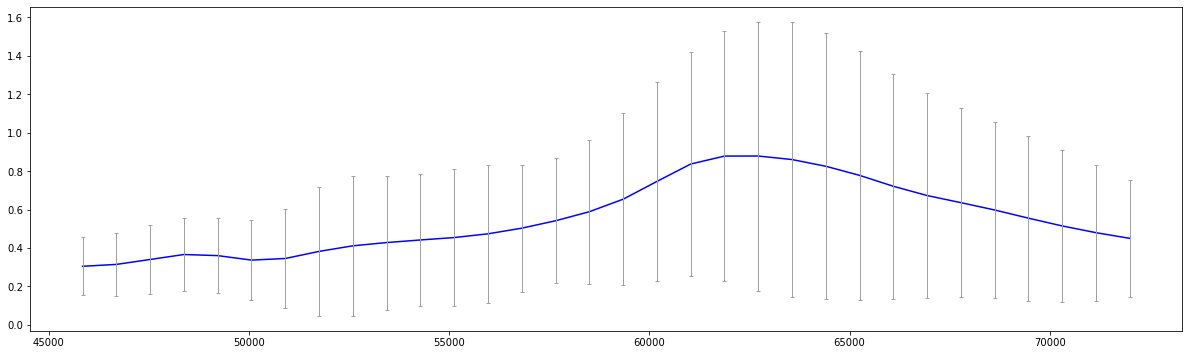

In [124]:
def ajusteGauss(nt, j, lGauss): #ySigma #ySigmaNoErrorBars
    xt, x_sal, inter, ytemp, sigtemp, siginter = distanciasJ(j, lGauss)
    gauss_funct, parametros = nTerminos(nt)
    #print(parametros)
    
    fig = plt.figure(figsize=(16,4.5), frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    #ax.errorbar(xt, ytemp, sigtemp, color='b', ecolor="#a1a1a1", barsabove=True, elinewidth = 1,  capsize=2)    
    ax.errorbar(x_sal, inter, siginter, color='b', ecolor="#a1a1a1", barsabove=True, elinewidth = 1,  capsize=2)
    
    ySigma = True
    if ySigma == True:
        popt2, pcov2 = curve_fit(gauss_funct, 
                         x_sal, 
                         inter, 
                         p0=parametros, 
                         sigma=siginter, 
                         absolute_sigma=True)
        yhatSigmas = gauss_funct(x_sal, *popt2)
        ax.plot(x_sal, yhatSigmas, "#1bfa50", linewidth=1, label="No Sigmas")
        #print(a)

    #if ySigmaNoErrorBars == True:
    #    popt, pcov = curve_fit(gauss_funct, 
    #                   x_sal, 
    #                   inter, 
    #                   p0=a)
    #    yhat = gauss_funct(x_sal, *popt)
    #    ax.plot(x_sal, yhat, '#fd4c8a', linewidth=1)
    ax.set_facecolor('black')
    plt.title("Gauss plot {}".format(j))
    plt.xlabel("Tiempo en segundos")
    plt.xlim((25000,85000))
    plt.ylim((0,5))
    plt.show()

interact(ajusteGauss,
         nt  = widgets.IntSlider(min=3,max=6,step=1, value=5),
         j = widgets.IntSlider(min=0, max=95, step=5, value=70),
         #ySigmaNoErrorBars = widgets.Checkbox(value=False,description='Use python fit',disabled=False,indent=False),
         #ySigma = widgets.Checkbox(value=True,description='Use IDL fit (give standar deviations)',disabled=False,indent=False),
         lGauss = widgets.IntSlider(min=10, max=30, step=1, value=16)
)

In [125]:
xt

[30600.0,
 32400.005,
 34200.001,
 36000.0,
 37800.0,
 39600.0,
 41400.0,
 43200.004,
 45000.003,
 46800.001,
 48600.002,
 50400.0,
 52200.0,
 54000.0,
 55800.001,
 57599.999,
 59400.0,
 61200.0,
 63000.001,
 64800.001,
 66600.001,
 68400.005,
 70200.004,
 72000.001,
 75600.0]

In [126]:
len(ytemp)

25

In [127]:
len(xt)

25